Second try, with a basic model

Imports

In [150]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

Choose a model

In [151]:
model_name = 'resnet18'
print(f'Using model: {model_name}')

Using model: resnet18


Load and prepare the dataset

In [152]:
image_height = 64
image_width = 64
batch_size = 32

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),  # Resize images to a fixed size
    transforms.ToTensor(),                           # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5],      # Normalize pixel values
                         std=[0.5, 0.5, 0.5])])

# Specify the path to your dataset
data_dir = 'fonts'

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create a DataLoader to handle batching and shuffling
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Calculate the size of the dataset
num_images = len(dataset)
num_batches = len(data_loader)
print(f'Number of images: {num_images}')
print(f'Number of batches: {num_batches}')

# Get the class names
class_names = dataset.classes
print(f'Class names: {class_names}')

Number of images: 15000
Number of batches: 469
Class names: ['Algerian', 'Arial', 'Baskerville', 'Calibry', 'Calligraphy', 'Cambria', 'Comic Sans MS', 'Courier', 'Elephant', 'Fascinate', 'Georgia', 'Helvetica', 'Lucida Bright', 'Nasalization', 'Times New Roman']


Load the model

In [153]:
# Load the model
model = models.__dict__[model_name](weights=None)
model.eval()

# Print the model architecture
# print(model)

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    
# Is MPS even available? macOS 12.3+
print(torch.backends.mps.is_available())

# Was the current version of PyTorch built with MPS activated?
print(torch.backends.mps.is_built())

# Move the model to the GPU
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)
print(f'Moving the model to {device}')

# Print the model's state_dict
# print('Model state_dict:')
# for param_tensor in model.state_dict():
    # print(param_tensor, '\t', model.state_dict()[param_tensor].size())

tensor([1.], device='mps:0')
True
True
Moving the model to mps


Train the model

In [154]:
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n-------------------------------')
    print("Len data loader:", len(data_loader))
    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{num_batches}], Loss: {loss.item():.4f}')
            
print('Finished Training')

# Save the model
model_path = f'{model_name}_font_classifier.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# Load the model
model = models.__dict__[model_name](weights=None)
model.load_state_dict(torch.load(model_path))
model.eval()
model = model.to(device)
print(f'Model loaded from {model_path}')

Epoch 1
-------------------------------
Len data loader: 469
Step: 0
Epoch [1/10], Step [10/469], Loss: 3.7843
Step: 10
Epoch [1/10], Step [20/469], Loss: 3.3466
Step: 20
Epoch [1/10], Step [30/469], Loss: 2.8175
Step: 30
Epoch [1/10], Step [40/469], Loss: 2.7863
Step: 40
Epoch [1/10], Step [50/469], Loss: 2.7646
Step: 50
Epoch [1/10], Step [60/469], Loss: 2.7924
Step: 60
Epoch [1/10], Step [70/469], Loss: 2.7308
Step: 70
Epoch [1/10], Step [80/469], Loss: 2.7028
Step: 80
Epoch [1/10], Step [90/469], Loss: 2.7349
Step: 90
Epoch [1/10], Step [100/469], Loss: 2.7291
Step: 100
Epoch [1/10], Step [110/469], Loss: 2.6604
Step: 110
Epoch [1/10], Step [120/469], Loss: 3.5893
Step: 120
Epoch [1/10], Step [130/469], Loss: 2.7662
Step: 130
Epoch [1/10], Step [140/469], Loss: 2.8967
Step: 140
Epoch [1/10], Step [150/469], Loss: 2.6970
Step: 150
Epoch [1/10], Step [160/469], Loss: 2.8343
Step: 160
Epoch [1/10], Step [170/469], Loss: 2.3049
Step: 170
Epoch [1/10], Step [180/469], Loss: 2.4747
Step:

Evaluate the model

Accuracy: 97.75%
Precision: 0.98
Recall: 0.98
F1-score: 0.98
Confusion Matrix:


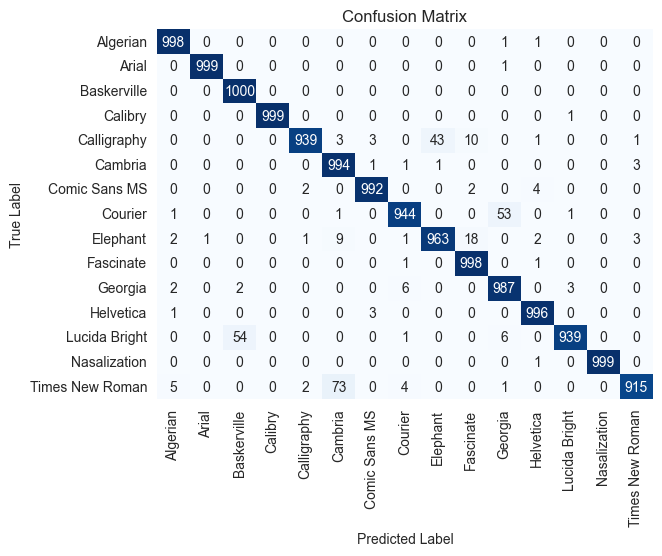

In [155]:
# Load the test dataset
test_data_dir = 'fonts'
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Set the model to evaluation mode
model.eval()

# Initialize lists for true labels and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_data_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Perform inference
        outputs = model(images)
        
        # Compute predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Append true and predicted labels to lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy: {:.2f}%'.format(100 * accuracy))

# Compute precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print('Precision: {:.2f}'.format(precision))

# Compute recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print('Recall: {:.2f}'.format(recall))

# Compute F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print('F1-score: {:.2f}'.format(f1))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(f'Confusion Matrix:')
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()